In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [3]:
df = pd.read_csv('user_reviews.csv')

In [4]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [6]:
df = df.dropna(subset=['Translated_Review', 'Sentiment'])

In [7]:
df.isna().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [8]:
df['Sentiment'].value_counts()

Sentiment
Positive    23998
Negative     8271
Neutral      5158
Name: count, dtype: int64

In [9]:
df['Sentiment'] = df['Sentiment'].map({'Positive':1, 'Neutral':0, 'Negative':-1})

Baseline model to check if sampling technique is required or not.

Accuracy: 0.8664173123163238

Classification Report:
               precision    recall  f1-score   support

          -1       0.79      0.87      0.83      1654
           0       0.66      0.93      0.77      1032
           1       0.97      0.85      0.91      4800

    accuracy                           0.87      7486
   macro avg       0.81      0.89      0.84      7486
weighted avg       0.89      0.87      0.87      7486



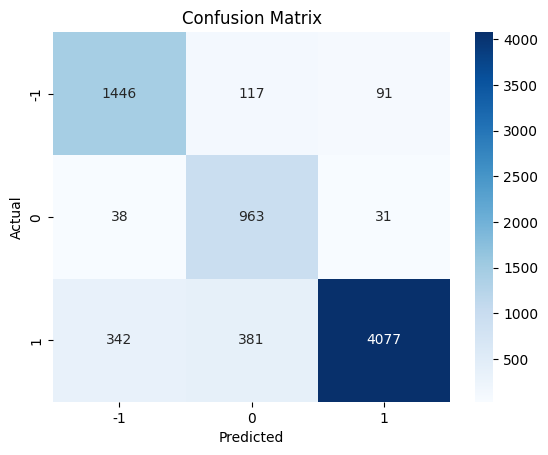

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Splitting into train & test
X_train, X_test, y_train, y_test = train_test_split(df['Translated_Review'], df['Sentiment'], test_size=0.2, stratify=df['Sentiment'], random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,1))  # Unigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression(max_iter=1000, class_weight="balanced")  # Handling imbalance
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Sampling needed - Oversampling.

In [11]:
X = df['Translated_Review']
y = df['Sentiment']

In [12]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(sampling_strategy={-1: int(0.65 * y.value_counts()[1]), 
                                           0: int(0.65 * y.value_counts()[1])}) # type: ignore

x_over, y_over = os.fit_resample(X.values.reshape(-1, 1), y)




In [13]:
df_resampled = pd.DataFrame({'Translated_Review': x_over.flatten(), 'Sentiment': y_over})

In [14]:
df_resampled['Sentiment'].value_counts()

Sentiment
 1    23998
 0    15598
-1    15598
Name: count, dtype: int64

In [15]:
df_resampled['word_count'] = df_resampled['Translated_Review'].apply(lambda x: len(x))
df_resampled['char_count'] = df_resampled['Translated_Review'].apply(lambda x: sum(len(word) for word in x))


In [16]:
avg_words = df_resampled['word_count'].mean()
avg_chars = df_resampled['char_count'].mean()
min_words = df_resampled['word_count'].min()
max_words = df_resampled['word_count'].max()

print(f"Average Words per Review: {avg_words}")
print(f"Average Characters per Review: {avg_chars}")
print(f"Min Words: {min_words}, Max Words: {max_words}")


Average Words per Review: 104.68376997499728
Average Characters per Review: 104.68376997499728
Min Words: 2, Max Words: 2713


In [17]:
sentiment_stats = df_resampled.groupby('Sentiment')[['word_count', 'char_count']].mean()

print(sentiment_stats)


           word_count  char_count
Sentiment                        
-1         136.948840  136.948840
 0          51.537248   51.537248
 1         118.256105  118.256105


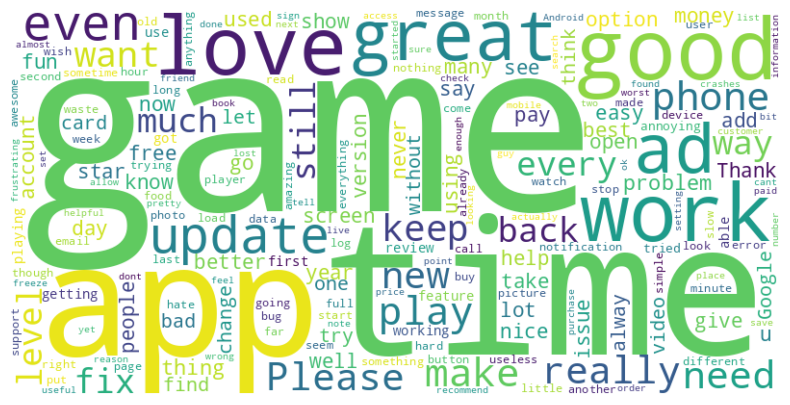

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Flatten the list of words into a single string
all_words = ' '.join([''.join(words) for words in df_resampled['Translated_Review']])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

/tmp/ipykernel_22045/1830605834.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_common, palette='viridis')


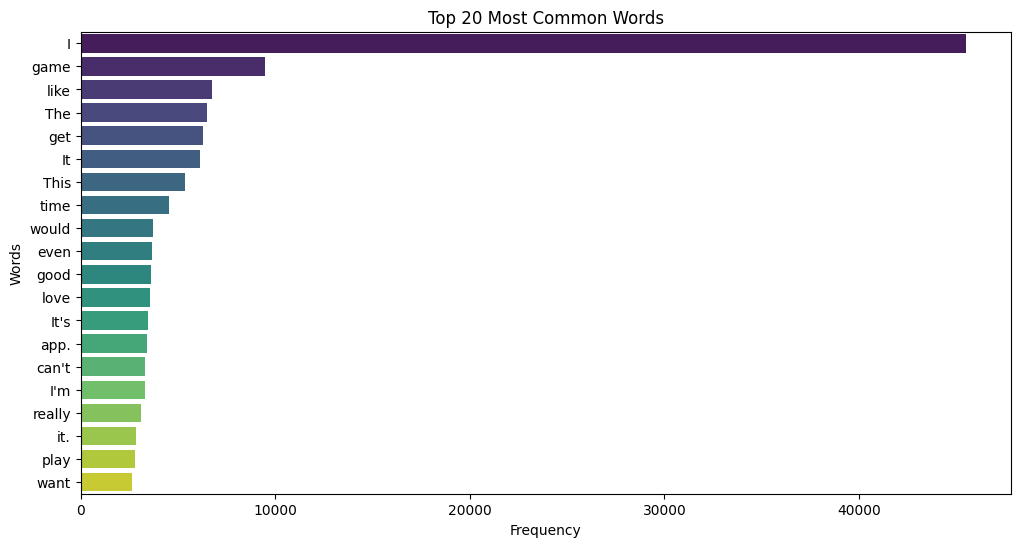

In [19]:
from collections import Counter
import seaborn as sns

# Flatten the list of words
word_list = [word for sublist in df_resampled['Translated_Review'] for word in sublist.split()]

# Count word frequencies
word_counts = Counter(word_list)
common_words = word_counts.most_common(20)  # Top 20 words

# Convert to DataFrame for visualization
import pandas as pd
df_common = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=df_common, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words')
plt.show()


In [20]:
df_resampled['Translated_Review'] = df_resampled['Translated_Review'].apply(lambda x: x.lower())

In [21]:
df_resampled['Translated_Review'].head(5)

0    i like eat delicious food. that's i'm cooking ...
1      this help eating healthy exercise regular basis
2           works great especially going grocery store
3                                         best idea us
4                                             best way
Name: Translated_Review, dtype: object

In [22]:
df_resampled['Translated_Review'][0]

'i like eat delicious food. that\'s i\'m cooking food myself, case "10 best foods" helps lot, also "best before (shelf life)"'

In [23]:
import re
df_resampled['Translated_Review'] = df_resampled['Translated_Review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [24]:
df_resampled['Translated_Review'][0]

'i like eat delicious food thats im cooking food myself case 10 best foods helps lot also best before shelf life'

In [25]:
from nltk import word_tokenize

df_resampled['Translated_Review'] = df_resampled['Translated_Review'].apply(lambda x: word_tokenize(x))

In [26]:
df_resampled['Translated_Review']

0        [i, like, eat, delicious, food, thats, im, coo...
1        [this, help, eating, healthy, exercise, regula...
2        [works, great, especially, going, grocery, store]
3                                         [best, idea, us]
4                                              [best, way]
                               ...                        
55189                                  [no, installed, sd]
55190                                   [s, a, m, p, a, h]
55191    [wish, easier, see, cumulative, time, totals, ...
55192         [theres, chat, messaging, way, chat, people]
55193    [what, nonsensical, app, doesnt, owner, postin...
Name: Translated_Review, Length: 55194, dtype: object

In [27]:
df_resampled['Translated_Review'][0]

['i',
 'like',
 'eat',
 'delicious',
 'food',
 'thats',
 'im',
 'cooking',
 'food',
 'myself',
 'case',
 '10',
 'best',
 'foods',
 'helps',
 'lot',
 'also',
 'best',
 'before',
 'shelf',
 'life']

In [28]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def filter_sentence(x):
    sentence = []
    for i in x:
        if i not in stop_words:
            sentence.append(i)
    return sentence

In [29]:
df_resampled['Translated_Review'] = df_resampled['Translated_Review'].apply(filter_sentence)

In [30]:
df_resampled['Translated_Review'][0]

['like',
 'eat',
 'delicious',
 'food',
 'thats',
 'im',
 'cooking',
 'food',
 'case',
 '10',
 'best',
 'foods',
 'helps',
 'lot',
 'also',
 'best',
 'shelf',
 'life']

In [31]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

porter = PorterStemmer()
lancaster = LancasterStemmer()


def stemmer(x, stemming):
    words = []
    for i in x:
        words.append(stemming.stem(i))
    return words


df_resampled['Translated_Review_Porter'] = df_resampled['Translated_Review'].apply(lambda x : stemmer(x, porter))

df_resampled['Translated_Review_Lancaster'] = df_resampled['Translated_Review'].apply(lambda x : stemmer(x, lancaster))

In [32]:
df_resampled[df_resampled['Translated_Review'] != df_resampled['Translated_Review_Porter']].head(2)

,Translated_Review,Sentiment,word_count,char_count,Translated_Review_Porter,Translated_Review_Lancaster
0,"[like, eat, delicious, food, thats, im, cookin...",1,122,122,"[like, eat, delici, food, that, im, cook, food...","[lik, eat, delicy, food, that, im, cook, food,..."
1,"[help, eating, healthy, exercise, regular, basis]",1,47,47,"[help, eat, healthi, exercis, regular, basi]","[help, eat, healthy, exerc, regul, bas]"


In [33]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/puskchan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [34]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemm = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatizer(x, lem=lemm):
    words = []
    pos_tagged = nltk.pos_tag(x)
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    for word, tag in wordnet_tagged:
        if tag is None:
            words.append(word)
        else:
            words.append(lem.lemmatize(word,tag))
    
    return words

df_resampled['Translated_Review_Lemmatization'] = df_resampled['Translated_Review'].apply(lambda x : lemmatizer(x))

In [35]:
df_resampled[df_resampled['Translated_Review'] != df_resampled['Translated_Review_Lemmatization']]['Translated_Review_Lemmatization'][0]

['like',
 'eat',
 'delicious',
 'food',
 'thats',
 'im',
 'cook',
 'food',
 'case',
 '10',
 'best',
 'food',
 'help',
 'lot',
 'also',
 'best',
 'shelf',
 'life']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vect_bin = CountVectorizer(lowercase=False, binary=True)

X = vect_bin.fit_transform(df_resampled['Translated_Review_Lemmatization'][0])

print("Vocab:", vect_bin.get_feature_names_out())
print("Bow binary:")
print(X.toarray())

Vocab: ['10' 'also' 'best' 'case' 'cook' 'delicious' 'eat' 'food' 'help' 'im'
 'life' 'like' 'lot' 'shelf' 'thats']
Bow binary:
[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [37]:
test = df_resampled['Translated_Review_Lemmatization'][0] + df_resampled['Translated_Review_Lemmatization'][1] + df_resampled['Translated_Review_Lemmatization'][2]

In [38]:
vect_wbin = CountVectorizer(lowercase=False, binary=False)

X = vect_wbin.fit_transform(test)

print("Vocab:", vect_wbin.get_feature_names_out())
print("Bow without binary:")
print(X.toarray())

Vocab: ['10' 'also' 'basis' 'best' 'case' 'cook' 'delicious' 'eat' 'especially'
 'exercise' 'food' 'go' 'great' 'grocery' 'healthy' 'help' 'im' 'life'
 'like' 'lot' 'regular' 'shelf' 'store' 'thats' 'work']
Bow without binary:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0

In [39]:
k = df_resampled['Translated_Review'][3]
test1 = " ".join(k)
test1

'best idea us'

In [40]:
test1 = [
    'like eat delicious food thats im cooking food case 10 best foods helps lot also best shelf life',
    'help eating healthy exercise regular basis',
    'works great especially going grocery store',
    'best idea us',
]

In [41]:
vect_ngram = CountVectorizer(lowercase=False, ngram_range=(1,2))

X = vect_ngram.fit_transform(test1)

print("Vocab:", vect_wbin.get_feature_names_out())
print("Bow ngram:")
print(X.toarray())

Vocab: ['10' 'also' 'basis' 'best' 'case' 'cook' 'delicious' 'eat' 'especially'
 'exercise' 'food' 'go' 'great' 'grocery' 'healthy' 'help' 'im' 'life'
 'like' 'lot' 'regular' 'shelf' 'store' 'thats' 'work']
Bow ngram:
[[1 1 1 1 0 2 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 2 1 1 1 1 0 0 0 0 0 0 0 0
  0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
  1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(test1)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print("\n🔹 TF-IDF Representation:\n", tfidf_df.head())


🔹 TF-IDF Representation:
          10      also     basis      best      case   cooking  delicious  \
0  0.220937  0.220937  0.000000  0.348378  0.220937  0.220937   0.220937   
1  0.000000  0.000000  0.408248  0.000000  0.000000  0.000000   0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
3  0.000000  0.000000  0.000000  0.486934  0.000000  0.000000   0.000000   

        eat    eating  especially  ...        im      life      like  \
0  0.220937  0.000000    0.000000  ...  0.220937  0.220937  0.220937   
1  0.000000  0.408248    0.000000  ...  0.000000  0.000000  0.000000   
2  0.000000  0.000000    0.408248  ...  0.000000  0.000000  0.000000   
3  0.000000  0.000000    0.000000  ...  0.000000  0.000000  0.000000   

        lot   regular     shelf     store     thats        us     works  
0  0.220937  0.000000  0.220937  0.000000  0.220937  0.000000  0.000000  
1  0.000000  0.408248  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.0000

In [43]:
tfidf_df.T

,0,1,2,3
10,0.220937,0.000000,0.000000,0.000000
also,0.220937,0.000000,0.000000,0.000000
basis,0.000000,0.408248,0.000000,0.000000
best,0.348378,0.000000,0.000000,0.486934
case,0.220937,0.000000,0.000000,0.000000
cooking,0.220937,0.000000,0.000000,0.000000
delicious,0.220937,0.000000,0.000000,0.000000
eat,0.220937,0.000000,0.000000,0.000000
eating,0.000000,0.408248,0.000000,0.000000
especially,0.000000,0.000000,0.408248,0.000000


In [44]:
df_resampled['Translated_Review_tfidf'] = df_resampled['Translated_Review'].apply(lambda x: " ".join(x))

In [45]:
tfidf_result = tfidf.fit_transform(df_resampled['Translated_Review_tfidf'])

result = pd.DataFrame(tfidf_result.toarray(), columns=tfidf.get_feature_names_out())
result

,00,000,0000,00000,000000000000000000000000000000000000000000000000000000001,0015,004,00love,00mm,010,...,ಕನನಡದ,നട,ပစလပတယ,ပမယ,လတ,သက,သခငတလတ,အဉ,搵楼租楼,无言
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result, df_resampled['Sentiment'], test_size=0.2, random_state=42)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logit = LogisticRegression(solver='saga', max_iter=100)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9330555303922456
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.92      3100
           0       0.91      0.97      0.94      3106
           1       0.95      0.93      0.94      4833

    accuracy                           0.93     11039
   macro avg       0.93      0.93      0.93     11039
weighted avg       0.93      0.93      0.93     11039

Confusion Matrix:
 [[2800  120  180]
 [  40 3022   44]
 [ 162  193 4478]]


In [51]:
tfidf_result = tfidf.transform(["Hello how are you!", "You are amazing!", "The product was amazing to use and I loved it!", "I hate this product"])

result = pd.DataFrame(tfidf_result.toarray(), columns=tfidf.get_feature_names_out())
result

,00,000,0000,00000,000000000000000000000000000000000000000000000000000000001,0015,004,00love,00mm,010,...,ಕನನಡದ,നട,ပစလပတယ,ပမယ,လတ,သက,သခငတလတ,အဉ,搵楼租楼,无言
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y_pred = logit.predict(result)


In [53]:
y_pred

array([ 0,  1,  1, -1])